# Experiment on AMSGrad -- pytorch version

Author: Weikai Qi

Email: wikaiqi@gmail.com

Last modified: 2018-05-29

One of the ICLR best research paper 'On the convergence of ADAM and beyond' points out that the original ADAM does not converge to the optimal solution:
https://openreview.net/forum?id=ryQu7f-RZ

The problem can be solved by using the maximum of all $v_t$ until the present time step and uses this maximum value for normalizing the running average of the gradient instead of $v_t$ in ADAM:
$$
v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2
$$
$$
\hat{v}_t = max(\hat{v}_{t-1}, v_t)
$$
This variant is called AMSGrad. Now those popular deep learning software, such as Keras and pytorch have updated the Adam by adding an option (amsgrad = False/True). 



In this kernel, I will test the synthetic experiments of online learning with the pytorch Adam and AMSGrad implementation:
\begin{eqnarray}
f_t(x) &=& 1010x ~(if ~t~mod~101 = 1) \\
f_t(x) &=& -10x   ~else
\end{eqnarray}
where $x=[-1, 1]$. The optimal solution is $x = -1$. And the stochastic optimization:
\begin{eqnarray}
f_t(x) &=& 1010x ~(with~probability~0.01 ) \\
f_t(x) &=& -10x   ~else
\end{eqnarray}



In [8]:
#python 
import torch
import numpy as np
import matplotlib.pylab as plt
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm

%matplotlib inline 

In [9]:
#define torch variables
xmax = Variable(torch.Tensor([1.0]), requires_grad=True)
xmin = Variable(torch.Tensor([-1.0]), requires_grad=True)

# define objective finction
def constrain(x):
    if x > 1.0:
        x = xmax
    if x < -1.0:
        x = xmin
    return x

def ft(x, t):
    if t%101 == 1:
        return x*1010.0
    else:
        return -10.0*x
    
def fmin(t):
    if t%101 == 1:
        return -1010.0
    else:
        return 10.0

## Online learning

The authors calculated the average regret which defined as:
$$
<R_t> = \frac{1}{T}\left(\sum_{i = 1}^{T} f_t(x_t) - min \sum_{i = 1}^{T} f_t(x)\right)
$$
A model converges to the optimal solution when $R_t = o(T)$.

In [3]:
def Ft_OnlineLearning(learning_rate=1e-3, amsgrad=False):
    '''
        Online learning experiment
        Input: learning_rate, amsgrad = Ture/False
        Ouput: Ft_step -- time step, 
               Ft_Rt   -- average regret,
               Ft_x    -- value of the iterate
    '''
    x    = Variable(torch.Tensor([0.5]), requires_grad=True)

    
    optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.9, 0.99), eps=1e-8, amsgrad=amsgrad)
    Rt_sum   = 0
    Ft_step = []
    Ft_Rt   = []
    Ft_x    = []

    for step in tqdm(range(1,6000001)):
        x    = constrain(x)
        loss = ft(x, step)

        Rt_sum += (loss.item() - fmin(step))
        avg_Rt = Rt_sum/step

        if step%10000 == 0:
            #print(step, loss.item(), x.item(), avg_Rt)
            Ft_step.append(step)
            Ft_Rt.append(avg_Rt)
            Ft_x.append(x.item())

        # manually zero all previous gradients
        optimizer.zero_grad()
        # calculate new gradients
        loss.backward()
        # apply new gradients
        optimizer.step()    
    
    return Ft_step, Ft_Rt, Ft_x

In [30]:
def plot_Res(Adam_step, Adam_Rt, Adam_x, amsg_step, amsg_Rt, amsg_x, lr):
    
    title = 'Learning rate = ' + str(lr)
    plt.figure(figsize=(18,6))
    plt.subplot(1, 2, 1)

    
    plt.plot(Adam_step, Adam_Rt, label='Adam')
    plt.plot(amsg_step, amsg_Rt,label='AMSGrad')
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    plt.legend(fontsize=14)
    plt.title(title)
    plt.axis([0,6000000, 0, 1])
    plt.xlabel('Iterations', fontsize=18)
    plt.ylabel('Rt/t', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)


    plt.subplot(1, 2, 2)
    plt.plot(Adam_step, Adam_x, label='Adam')
    plt.plot(amsg_step, amsg_x,label='AMSGrad')
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    plt.legend(fontsize=14)
    plt.title(title)
    plt.axis([0,6000000, -1.1, 1.1])
    plt.xlabel('Iterations', fontsize=18)
    plt.ylabel('xt', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)

100%|██████████| 6000000/6000000 [06:08<00:00, 16287.01it/s]


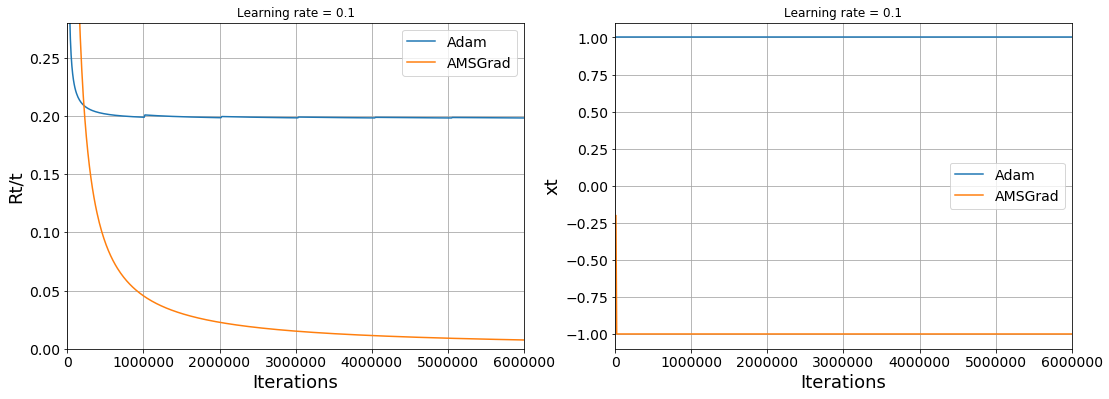

In [7]:
# Adam
lr = 1e-1
Adam_step, Adam_Rt, Adam_x = Ft_OnlineLearning(learning_rate=lr, amsgrad=False)

# AMSGrad
amsg_step, amsg_Rt, amsg_x = Ft_OnlineLearning(learning_rate=lr, amsgrad=True)

plot_Res(Adam_step, Adam_Rt, Adam_x, amsg_step, amsg_Rt, amsg_x,lr)

100%|██████████| 6000000/6000000 [05:50<00:00, 17111.21it/s]


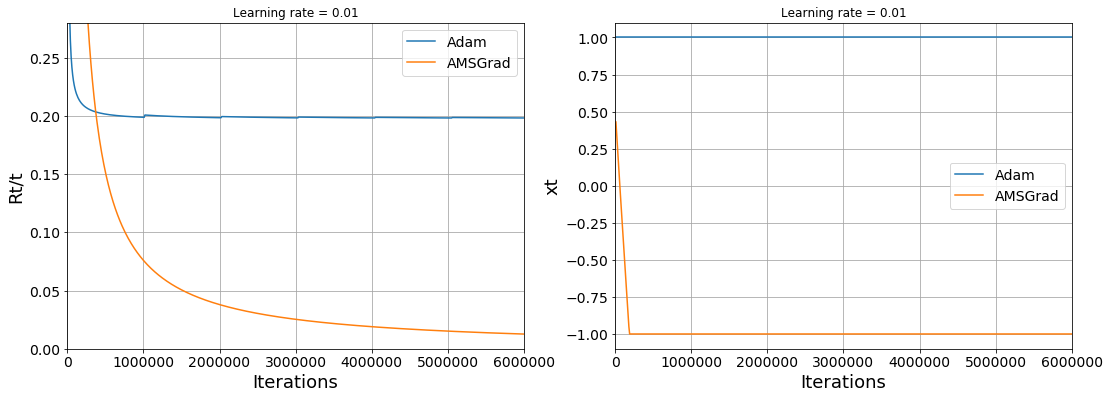

In [5]:
# Adam
lr = 1e-2
Adam_step, Adam_Rt, Adam_x = Ft_OnlineLearning(learning_rate=lr, amsgrad=False)

# AMSGrad
amsg_step, amsg_Rt, amsg_x = Ft_OnlineLearning(learning_rate=lr, amsgrad=True)

plot_Res(Adam_step, Adam_Rt, Adam_x, amsg_step, amsg_Rt, amsg_x,lr)

100%|██████████| 6000000/6000000 [05:46<00:00, 17335.23it/s]


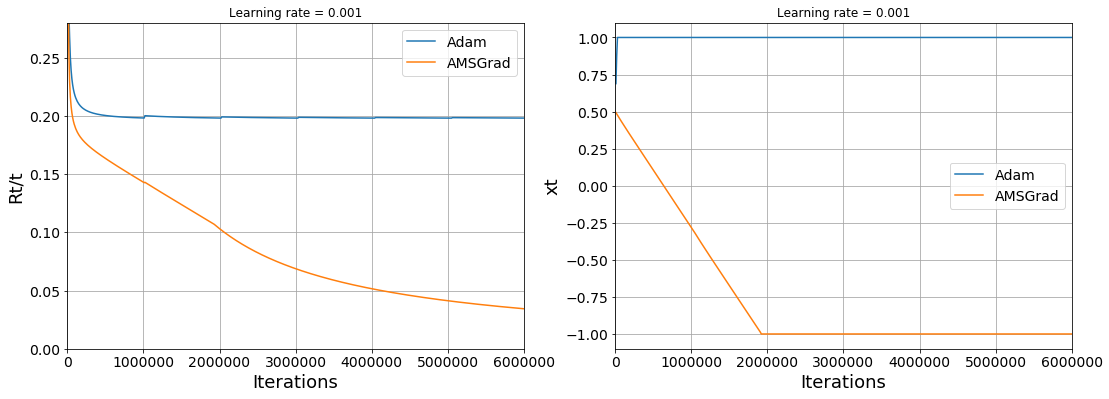

In [6]:
# Adam
lr = 1e-3
Adam_step, Adam_Rt, Adam_x = Ft_OnlineLearning(learning_rate=lr, amsgrad=False)

# AMSGrad
amsg_step, amsg_Rt, amsg_x = Ft_OnlineLearning(learning_rate=lr, amsgrad=True)

plot_Res(Adam_step, Adam_Rt, Adam_x, amsg_step, amsg_Rt, amsg_x,lr)


The paper does not mention what's the learning rate used their experiment (Fig 1 in the paper), which makes it hard to directly compare with their results. From the above experiments, I can make some conclusions:
- Adam does not converge to the optimal solution
- AMSGrad always converge to the optimal solution
- The performance of AMSGrad depends on the learning rate

## Stochastic optimization


In [26]:
from torch.distributions import Bernoulli
Bern_exp = Bernoulli(0.01)

def ft_sto(x):
    
    r = Bern_exp.sample() 
    loss = (r*1010.0 + (1 - r) * (-10.0))*x
    return loss, r

def fmin_sto(r):
    if r > 0.5:
        return -1010.0
    else:
        return 10.0
   

In [27]:
def Ft_Stochastic(learning_rate=1e-3, amsgrad=False):
    '''
        Online learning experiment
        Input: learning_rate, amsgrad = Ture/False
        Ouput: Ft_step -- time step, 
               Ft_Rt   -- average regret,
               Ft_x    -- value of the iterate
    '''
    x    = Variable(torch.Tensor([0.5]), requires_grad=True)

    
    optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.9, 0.99), eps=1e-8, amsgrad=amsgrad)
    Rt_sum   = 0
    Ft_step = []
    Ft_Rt   = []
    Ft_x    = []

    for step in tqdm(range(1,6000001)):
        x     = constrain(x)
        loss,r = ft_sto(x)

        Rt_sum += (loss.item() - fmin(r))
        avg_Rt = Rt_sum/step

        if step%10000 == 0:
            #print(step, loss.item(), x.item(), avg_Rt)
            Ft_step.append(step)
            Ft_Rt.append(avg_Rt)
            Ft_x.append(x.item())

        # manually zero all previous gradients
        optimizer.zero_grad()
        # calculate new gradients
        loss.backward()
        # apply new gradients
        optimizer.step()    
    
    return Ft_step, Ft_Rt, Ft_x

100%|██████████| 6000000/6000000 [09:49<00:00, 10172.78it/s]


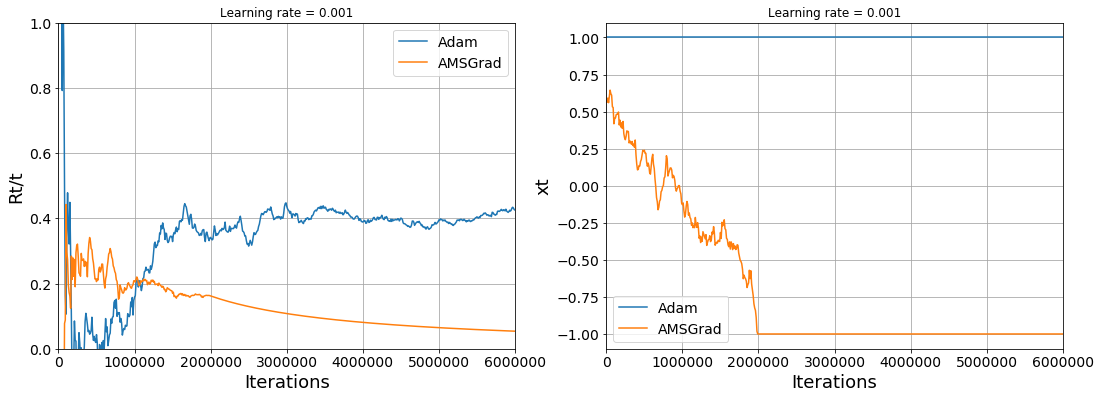

In [31]:
# Adam
lr = 1e-3
Adam_step, Adam_Rt, Adam_x = Ft_Stochastic(learning_rate=lr, amsgrad=False)

# AMSGrad
amsg_step, amsg_Rt, amsg_x = Ft_Stochastic(learning_rate=lr, amsgrad=True)

plot_Res(Adam_step, Adam_Rt, Adam_x, amsg_step, amsg_Rt, amsg_x,lr)